# The Challenge:
    Get out your dowsing rods, electromagnetic sensors, … and gradient boosting machines. Kaggle is haunted and we need your help. After a month of making scientific observations and taking careful measurements, we’ve determined that 900 ghouls, ghosts, and goblins are infesting our halls and frightening our data scientists. When trying garlic, asking politely, and using reverse psychology didn't work, it became clear that machine learning is the only answer to banishing our unwanted guests.

    So now the hour has come to put the data we’ve collected in your hands. We’ve managed to identify 371 of the ghastly creatures, but need your help to vanquish the rest. And only an accurate classification algorithm can thwart them. Use bone length measurements, severity of rot, extent of soullessness, and other characteristics to distinguish (and extinguish) the intruders. Are you ghost-busters up for the challenge?

# Notes:

File descriptions

    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - a sample submission file in the correct format

Data fields

    id - id of the creature
    bone_length - average length of bone in the creature, normalized between 0 and 1
    rotting_flesh - percentage of rotting flesh in the creature
    hair_length - average hair length, normalized between 0 and 1
    has_soul - percentage of soul in the creature
    color - dominant color of the creature: 'white','black','clear','blue','green','blood'
    type - target variable: 'Ghost', 'Goblin', and 'Ghoul'


# 1. Import Libraries:

In [1]:
#DF
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

#Common Model Algorithms
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

#Common Model Helpers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

### 1.A Sample Submission:

In [2]:
from IPython.display import display_html 

sample_submission = pd.read_csv('sample_submission.csv')

sample_head = sample_submission.head()
sample_tail = sample_submission.tail()
sample_sample = sample_submission.sample(5)

df1_styler = sample_head.style.set_table_attributes("style='display:inline'").set_caption('Head')
df2_styler = sample_tail.style.set_table_attributes("style='display:inline'").set_caption('Tail')
df3_styler = sample_sample.style.set_table_attributes("style='display:inline'").set_caption('Random Sample')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+ df3_styler._repr_html_(), raw=True)

,id,type
0,3,Ghost
1,6,Ghost
2,9,Ghost
3,10,Ghost
4,13,Ghost
,id,type
524,893,Ghost
525,894,Ghost
526,895,Ghost
527,898,Ghost


# 2. Meet and Greet Data:

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape

(371, 7)

In [5]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [6]:
train.tail()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost
370,897,0.670200,0.768469,0.737274,0.608384,white,Ghoul


In [7]:
train.sample(5)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
231,574,0.275021,0.689975,0.586513,0.402749,clear,Goblin
361,867,0.501022,0.584847,0.656230,0.469886,clear,Ghoul
114,266,0.489132,0.481304,0.482691,0.460081,white,Goblin
180,435,0.340442,0.531701,0.428498,0.263063,white,Ghost
25,47,0.229010,0.567313,0.373743,0.329636,white,Ghost


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [9]:
train.isna().sum().sort_values(ascending = False)

type             0
color            0
has_soul         0
hair_length      0
rotting_flesh    0
bone_length      0
id               0
dtype: int64

In [10]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [11]:
type_count = train['type'].value_counts().reset_index()

print(f"The number of monsters are {type_count.iloc[:]}.")

The number of monsters are     index  type
0   Ghoul   129
1  Goblin   125
2   Ghost   117.


In [12]:
num_cols = train[train.select_dtypes(exclude=['object']).columns]
cat_cols = train[train.select_dtypes(include=['object']).columns]

print(f'The numerical cols are: {list(num_cols)} ({len(list(num_cols))}).\n')
print(f'The categorical cols are: {list(cat_cols)} ({len(list(cat_cols))}).\n')
print(f'Total number of cols: {len(list(train))}')

The numerical cols are: ['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul'] (5).

The categorical cols are: ['color', 'type'] (2).

Total number of cols: 7


# 3. EDA Analysis:

In [13]:
def tight():
    plt.tight_layout()
    plt.show()

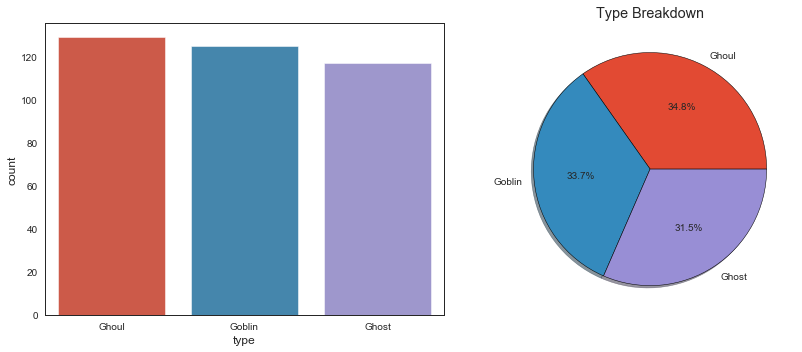

In [14]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1,figsize =(12,5))

sns.countplot(train['type'],ax =ax1)
ax2.pie(train['type'].value_counts(),shadow = True,wedgeprops = {'edgecolor':'black'},autopct='%1.1f%%', labels = ['Ghoul','Goblin','Ghost'])

plt.title('Type Breakdown')
tight()

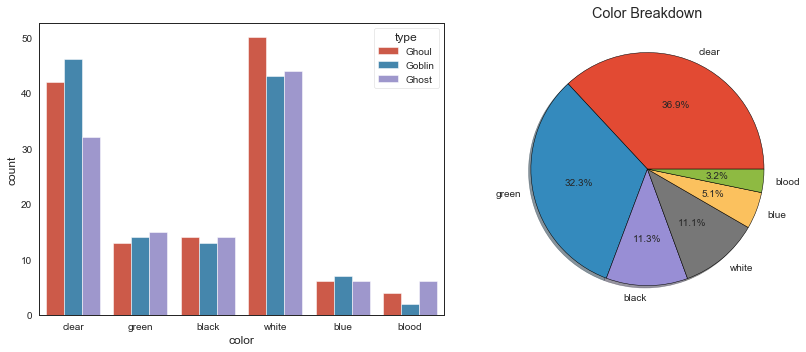

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1,figsize =(12,5))

sns.countplot(train['color'],ax =ax1,hue = train['type'])
ax2.pie(train['color'].value_counts(),shadow = True,wedgeprops = {'edgecolor':'black'},autopct='%1.1f%%',
       labels = ['clear','green','black','white','blue','blood'])

plt.title('Color Breakdown')
tight()

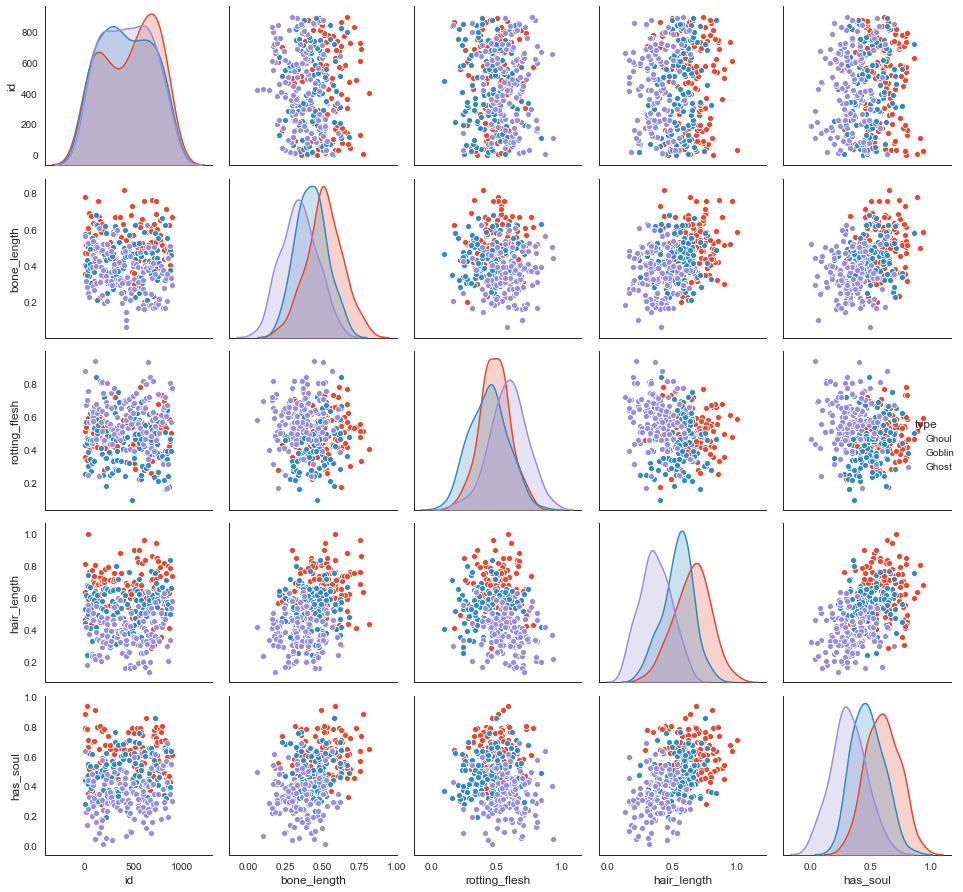

In [16]:
sns.pairplot(train, hue='type')

tight()

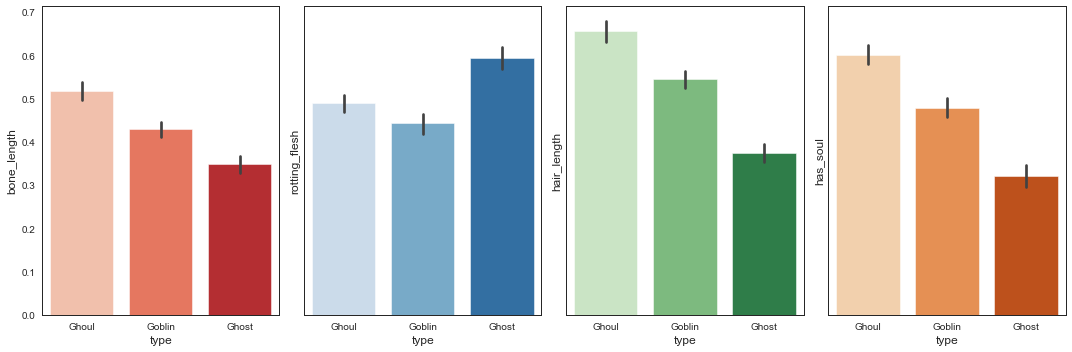

In [17]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols =4, nrows =1, figsize = (15,5),sharey = True)

sns.barplot(data = train, x = 'type', y = 'bone_length',ax =ax1,palette = 'Reds')
sns.barplot(data = train, x = 'type', y = 'rotting_flesh',ax =ax2, palette = 'Blues')
sns.barplot(data = train, x = 'type', y = 'hair_length',ax =ax3, palette = 'Greens')
sns.barplot(data = train, x = 'type', y = 'has_soul',ax =ax4, palette = 'Oranges')


tight()

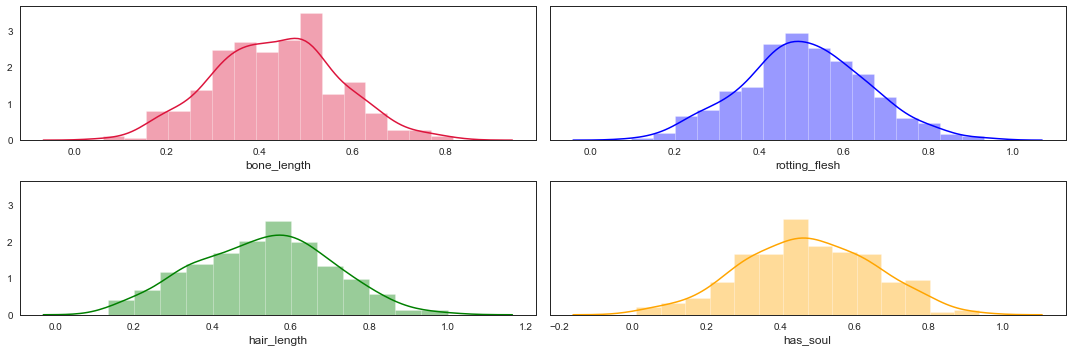

In [18]:
fig, ax = plt.subplots(2,2,figsize = (15,5),sharey = True)

sns.distplot(train['bone_length'],ax = ax[0,0], color = 'Crimson')
sns.distplot(train['rotting_flesh'],ax = ax[0,1],color = 'Blue')
sns.distplot(train['hair_length'],ax = ax[1,0], color ='Green')
sns.distplot(train['has_soul'],ax = ax[1,1], color ='Orange')

tight()

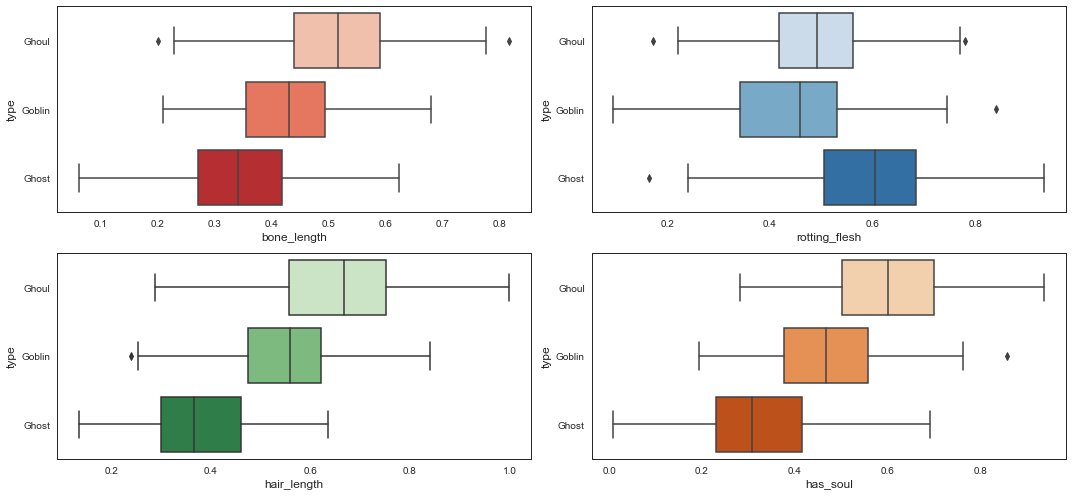

In [19]:
fig, ax = plt.subplots(2,2,figsize = (15,7))

sns.boxplot(data = train, x ='bone_length', y = 'type', ax = ax[0,0], palette = 'Reds')
sns.boxplot(data = train, x ='rotting_flesh', y = 'type', ax = ax[0,1], palette = 'Blues')
sns.boxplot(data = train, x ='hair_length', y = 'type', ax = ax[1,0], palette = 'Greens')
sns.boxplot(data = train, x ='has_soul', y = 'type', ax = ax[1,1], palette = 'Oranges')

tight()

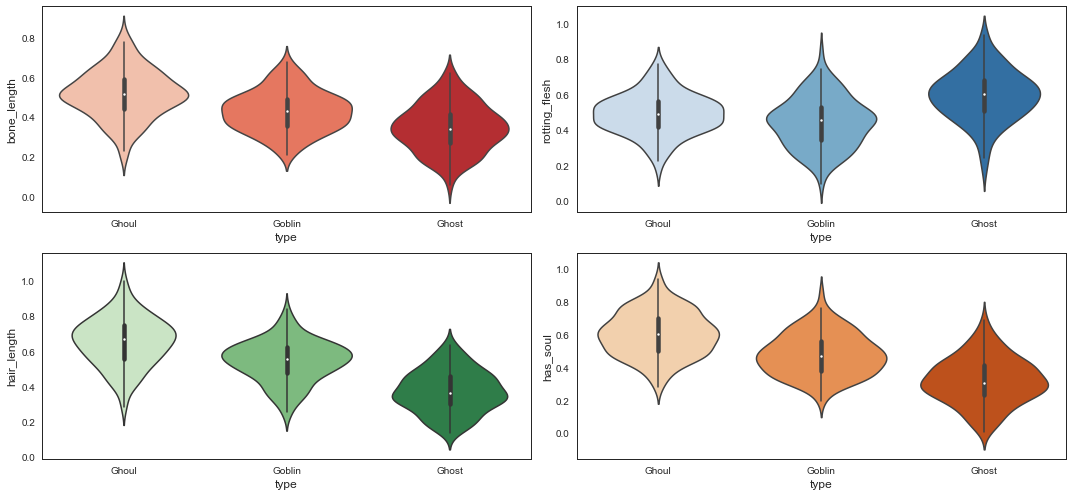

In [20]:
fig, ax = plt.subplots(2,2,figsize = (15,7))

sns.violinplot(data = train, y ='bone_length', x = 'type', ax = ax[0,0], palette = 'Reds')
sns.violinplot(data = train, y ='rotting_flesh', x = 'type', ax = ax[0,1], palette = 'Blues')
sns.violinplot(data = train, y ='hair_length', x = 'type', ax = ax[1,0], palette = 'Greens')
sns.violinplot(data = train, y ='has_soul', x = 'type', ax = ax[1,1], palette = 'Oranges')

tight()

type             1.000000
rotting_flesh    0.278228
color            0.046324
id              -0.043653
bone_length     -0.520687
has_soul        -0.649989
hair_length     -0.674640
Name: type, dtype: float64

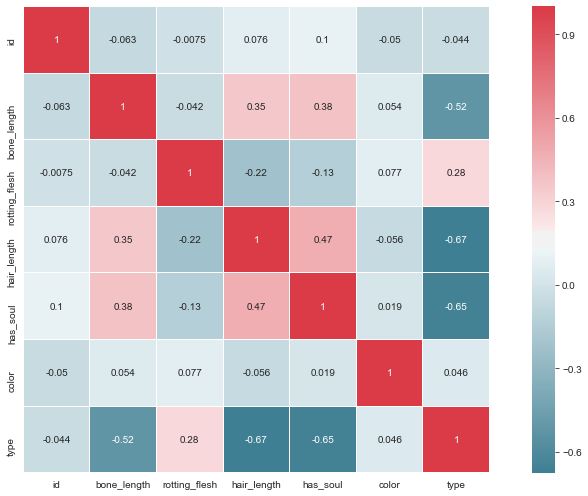

In [21]:
copy_train = train.copy()

copy_train['type'] = copy_train['type'].replace({'Ghoul':1, 'Goblin':2,'Ghost':3})
copy_train['color'] = copy_train['color'].replace({'white':0,'clear':1,'green':2,'black':3,'blue':4,'blood':5})

corr_matrix = copy_train.corr()

display(corr_matrix['type'].sort_values(ascending = False))
attributes = list(copy_train)

fig, ax = plt.subplots(figsize = (12,7))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr_matrix,linewidth = 0.01,vmax=1.0,square = True, cmap = colormap,annot = True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

tight()

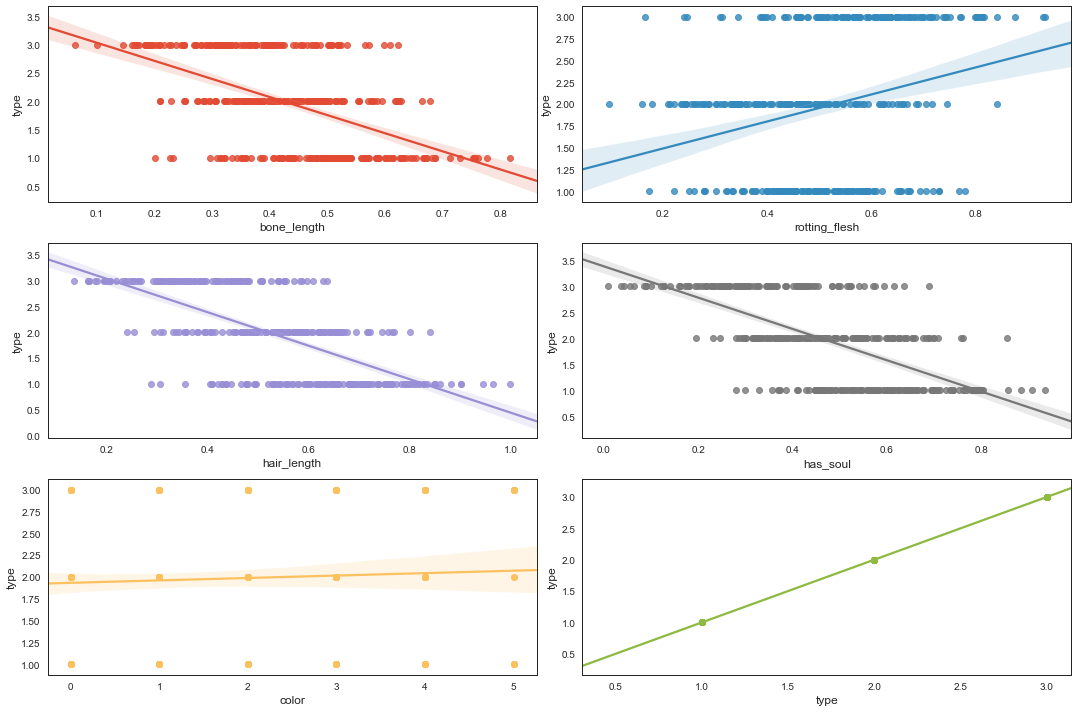

In [22]:
fig, ax = plt.subplots(3,2,figsize = (15,10))

sns.regplot(data = copy_train, x = 'bone_length', y ='type', ax = ax[0,0])
sns.regplot(data = copy_train, x = 'rotting_flesh', y ='type', ax = ax[0,1])
sns.regplot(data = copy_train, x = 'hair_length', y ='type', ax = ax[1,0])
sns.regplot(data = copy_train, x = 'has_soul', y ='type', ax = ax[1,1])
sns.regplot(data = copy_train, x = 'color', y ='type', ax = ax[2,0])
sns.regplot(data = copy_train, x = 'type', y ='type', ax = ax[2,1])

tight()

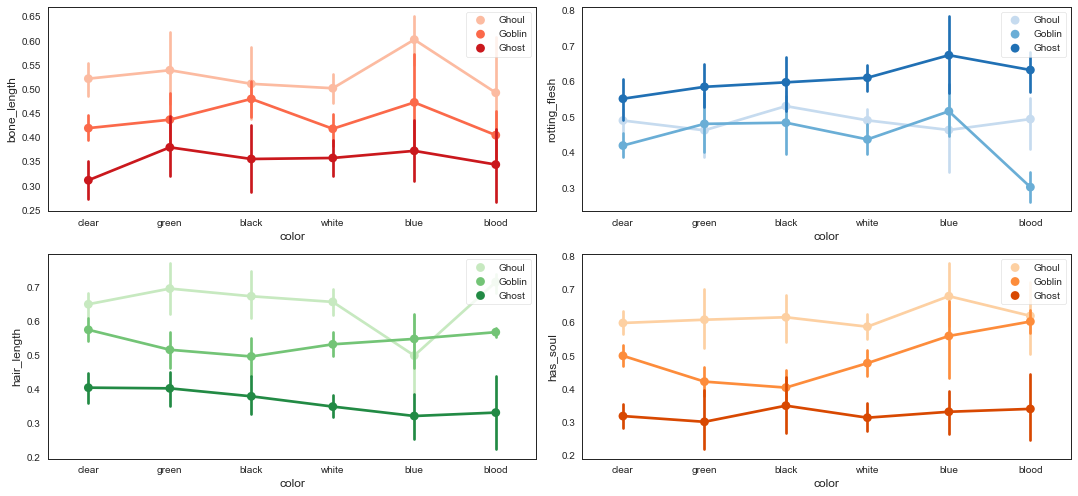

In [23]:
fig, ax = plt.subplots(2,2,figsize = (15,7))

sns.pointplot(data = train, y ='bone_length', x = 'color',hue = 'type', ax = ax[0,0], palette = 'Reds')
sns.pointplot(data = train, y ='rotting_flesh', x = 'color',hue ='type', ax = ax[0,1], palette = 'Blues')
sns.pointplot(data = train, y ='hair_length', x = 'color', hue= 'type',ax = ax[1,0], palette = 'Greens')
sns.pointplot(data = train, y ='has_soul', x = 'color', hue = 'type',ax = ax[1,1], palette = 'Oranges')

ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
ax[1,0].legend(loc='upper right')
ax[1,1].legend(loc='upper right')

tight()

# 4. Modelling:

In [24]:
X = train.copy()
y = train['type']

In [25]:
X = X.drop('type',axis=1)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [27]:
cat = list(X[X.select_dtypes(include=['object']).columns])
num = list(X[X.select_dtypes(exclude=['object']).columns])
my_cols = cat + num

In [28]:
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()
X_test = test[my_cols].copy()

In [29]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
    ])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),       
        ('cat',cat_transformer,cat),
        ])

le = preprocessing.LabelEncoder()

In [30]:
print("Data Shape: {}".format(train.shape))
print("X_train Shape: {}".format(X_train.shape))
print("y_train Shape: {}".format(y_train.shape))

Data Shape: (371, 7)
X_train Shape: (296, 6)
y_train Shape: (296,)


In [31]:
X_train_prepared = preprocessor.fit_transform(X_train)
y_train_prepared = le.fit_transform(y_train)

In [32]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# 5. Random Forest Classifier:

In [33]:
forest = RandomForestClassifier(n_estimators = 10)

forest.fit(X_train_prepared, y_train_prepared)
forest_predictions = forest.predict(X_train_prepared)

forest_mse = mean_squared_error(y_train_prepared, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

display(forest_rmse)

0.10067340828210365

### 5.1 Random Forest Classifier - CV Scores:

In [34]:
forest_scores = cross_val_score(forest, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Mean: 0.7251123443982631
Standard deviation: 0.09384072318120931


### 5.2 Random Forest Classifier - GridSearchCV

In [35]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [1,2,3],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [10, 100]}

forest_cv = GridSearchCV(forest, param_grid, n_jobs= 1, cv =10)
                  
forest_cv.fit(X_train_prepared, y_train_prepared)
print(forest_cv.best_params_)    
print(forest_cv.best_score_)

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
0.7398648648648649


In [36]:
forest_cv_predictions = forest_cv.predict(X_train_prepared)

# 6. SVC:

In [37]:
svc = SVC(gamma ='auto')

svc.fit(X_train_prepared, y_train_prepared)
svc_predictions = forest.predict(X_train_prepared)

svc_mse = mean_squared_error(y_train_prepared, svc_predictions)
svc_rmse = np.sqrt(svc_mse)

display(svc_rmse)

0.10067340828210365

### 6.1 SVC CV Scores:

In [38]:
svc_scores = cross_val_score(svc, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
svc_rmse_scores = np.sqrt(-svc_scores)

display_scores(svc_rmse_scores)

Mean: 0.7147756280943304
Standard deviation: 0.09009404018218327


### 6.2 SVC GridSearchCV:

# 7. Gradient Boosting Classifier:

In [39]:
gb = GradientBoostingClassifier(random_state = 10, learning_rate = 0.01)

gb.fit(X_train_prepared, y_train_prepared)
gb_predictions = gb.predict(X_train_prepared)

gb_mse = mean_squared_error(y_train_prepared, gb_predictions)
gb_rmse = np.sqrt(gb_mse)

display(gb_rmse)

0.43495883620084

### 7.1 Gradient Boosting Classifier CV Scores:

In [40]:
gb_scores = cross_val_score(gb, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
gb_rmse_scores = np.sqrt(-gb_scores)

display_scores(gb_rmse_scores)

Mean: 0.7269385330779132
Standard deviation: 0.13925262070993494


### 7.2 Gradient Boosting Clasifier GridSearchCV:

In [41]:
param_grid = { 
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth":[3,5,8],
    "n_estimators":[250,500]}

gb_cv = GridSearchCV(gb, param_grid, n_jobs= 1, cv =5)
                
gb_cv.fit(X_train_prepared, y_train_prepared)
print(gb_cv.best_params_)    
print(gb_cv.best_score_)

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.7094594594594594


# 8. Logistic Regression:

In [42]:
logreg = LogisticRegression(solver = 'liblinear',multi_class = 'auto')

logreg.fit(X_train_prepared, y_train_prepared)
logreg_predictions = logreg.predict(X_train_prepared)

logreg_mse = mean_squared_error(y_train_prepared, logreg_predictions)
logreg_rmse = np.sqrt(logreg_mse)

display(logreg_rmse)

0.6550221782917385

### 8.1 Logistic Regression CV Scores:

In [43]:
logreg_scores = cross_val_score(logreg, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
logreg_rmse_scores = np.sqrt(-logreg_scores)

display_scores(logreg_rmse_scores)

Mean: 0.7367210924767875
Standard deviation: 0.10940524151977425


### 8.2 Logistic Regression GridSearchCV:

In [44]:
param_grid = { 
    "C": [0.5,1.0,10.0,25.0,50.0],
    "solver":['liblinear','lbfgs','sag'],
    "max_iter":[500,1000,2500,5000],
}

logreg_cv = GridSearchCV(logreg, param_grid, n_jobs= 1, cv =5)
                
logreg_cv.fit(X_train_prepared, y_train_prepared)
print(logreg_cv.best_params_)    
print(logreg_cv.best_score_)

{'C': 0.5, 'max_iter': 500, 'solver': 'lbfgs'}
0.7567567567567568


C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 9. KNN Classifier:

In [45]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train_prepared, y_train_prepared)
knn_predictions = knn.predict(X_train_prepared)

knn_mse = mean_squared_error(y_train_prepared, knn_predictions)
knn_rmse = np.sqrt(knn_mse)

display(knn_rmse)

0.6040404496926218

### 9.1 KNN Classifier CV Scores:

In [46]:
knn_scores = cross_val_score(knn, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-knn_scores)

display_scores(knn_rmse_scores)

Mean: 0.7258658169847211
Standard deviation: 0.11326784848098125


### 9.2 KNN Classifier GridSearchCV:

In [47]:
param_grid = { 
    "n_neighbors": [1,5,10,25],
    "weights":['uniform','distance'],
    "leaf_size":[30,50,100],
    'algorithm':['auto','brute'],
}

knn_cv = GridSearchCV(knn, param_grid, n_jobs= 1, cv =10,iid = False)
                
knn_cv.fit(X_train_prepared, y_train_prepared)
print(knn_cv.best_params_)    
print(knn_cv.best_score_)

{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 25, 'weights': 'distance'}
0.7379310344827585


# 10. Linear SVM:

In [48]:
linear_svm = LinearSVC()

linear_svm.fit(X_train_prepared, y_train)
linear_svm_predictions = linear_svm.predict(X_train_prepared)

linear_svm_mse = mean_squared_error(y_train_prepared, knn_predictions)
linear_svm_rmse = np.sqrt(linear_svm_mse)

display(linear_svm_rmse)

0.6040404496926218

### 10.1 Linear SVM CV Scores:

In [49]:
linear_svm_scores = cross_val_score(linear_svm, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
linear_svm_rmse_scores = np.sqrt(-linear_svm_scores)

display_scores(linear_svm_rmse_scores)

Mean: 0.7217870521896861
Standard deviation: 0.11330843605241875


### 10.2 Linear SVM GridSearchCV:

In [50]:
param_grid = { 
    "C": [1.0,5.0,10.0,25.0],
    "max_iter":[20000,25000],
    "fit_intercept":[True,False],
}

linear_svm_cv = GridSearchCV(linear_svm, param_grid, n_jobs= 1, cv =10,iid = False)
                
linear_svm_cv.fit(X_train_prepared, y_train_prepared)
print(linear_svm_cv.best_params_)    
print(linear_svm_cv.best_score_)

{'C': 5.0, 'fit_intercept': True, 'max_iter': 20000}
0.7209121245828698


# 11. XGBoost:

In [51]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

xgb.fit(X_train_prepared, y_train_prepared)
xgb_predictions = xgb.predict(X_train_prepared)

xgb_mse = mean_squared_error(y_train_prepared, knn_predictions)
xgb_rmse = np.sqrt(linear_svm_mse)

display(xgb_rmse)

0.6040404496926218

### 11.1 XGBoost CV Scores:

In [52]:
xgb_scores = cross_val_score(xgb, X_train_prepared, y_train_prepared,scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores(xgb_rmse_scores)

Mean: 0.7185851684333797
Standard deviation: 0.07221418504566403


### 11.2 XGBoost GridSearchCV:

In [53]:
param_grid = {
        'n_estimators': [10,100,500],
        'gamma': [0.5, 1,5],
        'learning_rate':[0.01,0.02,0.05,0.10]
}

xgb_cv = GridSearchCV(xgb, param_grid, n_jobs= 1, cv =10,iid = False)
                
xgb_cv.fit(X_train_prepared, y_train_prepared)
print(xgb_cv.best_params_)    
print(xgb_cv.best_score_)

{'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.7264738598442715


# 12. Voting Classifier:

In [54]:
voting = VotingClassifier(estimators = [('xgb', xgb_cv),('linear_svm',linear_svm_cv),('logreg',logreg_cv)], voting = 'hard')

voting.fit(X_train_prepared, y_train_prepared)
voting_predictions = (X_train_prepared)

print("\nAccuracy Score for VotingClassifier is: " + str(voting.score(X_train_prepared, y_train_prepared)))


Accuracy Score for VotingClassifier is: 0.8006756756756757


C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 13. Final Model:

In [55]:
final_model = voting

X_test_prepared = preprocessor.transform(X_test)

In [56]:
final_predictions = final_model.predict(X_test_prepared)
final = le.inverse_transform(final_predictions)

In [57]:
output = pd.DataFrame({'id': X_test.id,
                       'type': final})

output.to_csv('submission.csv', index=False)